# Проект 3: О вкусной и здоровой пище
## Predict TripAdvisor Rating
**По ходу задачи:**
* Прокачаем работу с pandas
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* Применим ML модель для предсказания рейтингов ресторана   


Целью проекта является создание и обучение модели на имеющихся у нас данных.

Выполнение проекта делится на следующие этапы:
1. Импорт необходимых для работы функций и библиотек
2. Создание функций, используемых в проекте
3. EDA
4. Создание и описание новых признаков, необходимых для более точного обучения модели
5. Создание модели
6. Обучение модели
7. Оценка метрики MAE
8. Вывод

# import

In [1]:
# Импортируем необходимые библиотеки для обработки данных,построения графиков и преобразования дат
import os
from sklearn import metrics  # инструменты для оценки точности модели
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings
from datetime import datetime
import math
import numpy as np
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.simplefilter('ignore')
plt.rcParams['figure.figsize'] = (15, 7)

# Инструментарий,необходимый для разделения дата-сета:
# Импортируем необходимые библиотеки:

In [2]:
# Фиксирование значения RANDOM_SEED, позволяющиее воспроизводить проведенные эксперименты
RANDOM_SEED = 42

In [3]:
# фиксирование пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## Функции

In [4]:
# Функция для округления результатов предсказаний
def predict_rounder(y_pred):
    return [(round(y/0.5)*0.5) for y in y_pred]

# Функция для проверки на присутствие элемента из одного списка в другом


def top_check(column):
    for i in top_cuisines:  # Список кухонь
        if i in column:  # Искомый столбец
            return 1
    return 0

# Функция для выделения дат из столбца reviews


def review_dates(col):
    # разделяем исходную строку на массивы с датами и комментариями
    x = str(col)[2:-2].split('], [')
    if (len(x) < 2 or x[1] == ''):
        return []  # если отсутствуют даты,вернуть пустой массив
# Разделяем даты внутри массива и возвращаем в формате "старше,новее"
    to_time = pd.to_datetime(x[1].split(', '), format='\'%m/%d/%Y\'')
    time_min = to_time.min()
    time_max = to_time.max()
    return[time_min, time_max]

# Функция для проверки на присутствие ресторана в списке сетевых


def is_net_rest(column):
    for i in id_net_list:  # Проверяем в списке сетевых ресторанов
        if i in column:  # Проверяем в искомом столбце
            return 1
    return 0

# 1.DATA

В этом пункте проводится загрузка данных, первичный осмотр и описание приведенных в дата-сете столбцов

In [5]:
df = pd.read_csv('main_taskSF.xls')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [7]:
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
6342,id_9743,Paris,"['French', 'European']",9745.0,3.5,$$ - $$$,103.0,"[['typical french attitude', ""Look we're cool....",/Restaurant_Review-g187147-d1990809-Reviews-Me...,d1990809
38500,id_1076,London,"['Indian', 'Asian', 'Vegetarian Friendly', 'Ve...",1078.0,4.5,$$ - $$$,133.0,"[['Interesting and prisey', 'New years eve 201...",/Restaurant_Review-g186338-d10455238-Reviews-F...,d10455238
39933,id_5209,Paris,"['Indian', 'Asian']",5210.0,4.0,$$ - $$$,43.0,"[['Delicious Curry!', 'Just Okay food..'], ['0...",/Restaurant_Review-g187147-d8587751-Reviews-Go...,d8587751
27569,id_1062,Rome,"['Italian', 'Pizza', 'Fast Food', 'Street Food...",1063.0,4.5,$,502.0,"[['Best pizza', 'The best pizza in Rome!'], ['...",/Restaurant_Review-g187791-d1095877-Reviews-La...,d1095877
39692,id_596,Amsterdam,"['Cafe', 'Fusion', 'Healthy', 'French', 'Dutch...",597.0,5.0,$,42.0,"[['have a coffee and look around', 'Amazing fo...",/Restaurant_Review-g188590-d10136222-Reviews-C...,d10136222


In [8]:
df.Reviews[1]

"[['Unique cuisine', 'Delicious Nepalese food'], ['07/06/2017', '06/19/2016']]"

Данные засорены, во многих столбцах есть пропуски. Числовых столбцов среди представленного дата-сета мало, требуется дальнейшая предобработка. Кроме того, один из числовых столбцов является целевым. Для начала выделим еще раз, в каких столбцах отсутствуют значения и в каком количестве.

In [9]:
df.isnull().sum().sort_values(ascending=False)

Price Range          13886
Cuisine Style         9283
Number of Reviews     2543
ID_TA                    0
URL_TA                   0
Reviews                  0
Rating                   0
Ranking                  0
City                     0
Restaurant_id            0
dtype: int64

Таким образом, мы имеем 4 столбца, которые точно требуют определенной очистки и предобработки. При дальнейшем исследовании их может стать больше. Преобразуем названия столбцов в более удобные для дальнейшего использования:

In [10]:
df.columns = ['rest_id', 'city', 'cuisine_style', 'ranking', 'rating',
              'price_range', 'reviews_number', 'reviews', 'url_ta', 'id_ta']

In [11]:
df

,rest_id,city,cuisine_style,ranking,rating,price_range,reviews_number,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963
...,...,...,...,...,...,...,...,...,...,...
39995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,4.5,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414
39996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,3.5,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036
39997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,4.5,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615
39998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,4.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838


## 2. Обработка признаков

### 2.1. Нечисловые столбцы

### 2.1.1. А сетевой ли у нас ресторан или нет? Расмотрим столбец rest_id

In [12]:
df.rest_id.nunique()

11909

Мы видим, что, в отличии от общего количества строк (50000), уникальных значений в id ресторана всего 13094. Значит копаем глубже. Посчитаем, сколько ресторанов являются сетевыми:

In [13]:
# создаем список, в котором хранятся данные о том, сколько раз встречается каждый id ресторана в дата-сете
id_list = df.rest_id.value_counts()
len(id_list[id_list > 1])  # отфильтруем несетевые рестораны

7204

И правда, в дата-сете присутствует аж 7204 сетевых ресторана. Итого, мы имеем строковый столбец, из которого в дальнейшем получим новую информацию. Эти данные можно будет использовать при построении модели.

### 2.1.2. Столбец City

Посмотрим, получится ли что-то придумать со столбцом city, где хранится информация о городе ресторана.
Для начала стоит проверить сколько вообще имеется уникальных значений в данном столбце:

In [14]:
df.city.nunique()

31

Итак, мы имеем всего 31 город, не так уж и много. Теперь можно наглядно посмотреть, сколько раз встречается каждый город в нашем дата-сете:

In [15]:
df_cities_count = df.city.value_counts()
df_cities_count

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: city, dtype: int64

Построим график для большей наглядности:

Text(0.5, 0, 'Город')

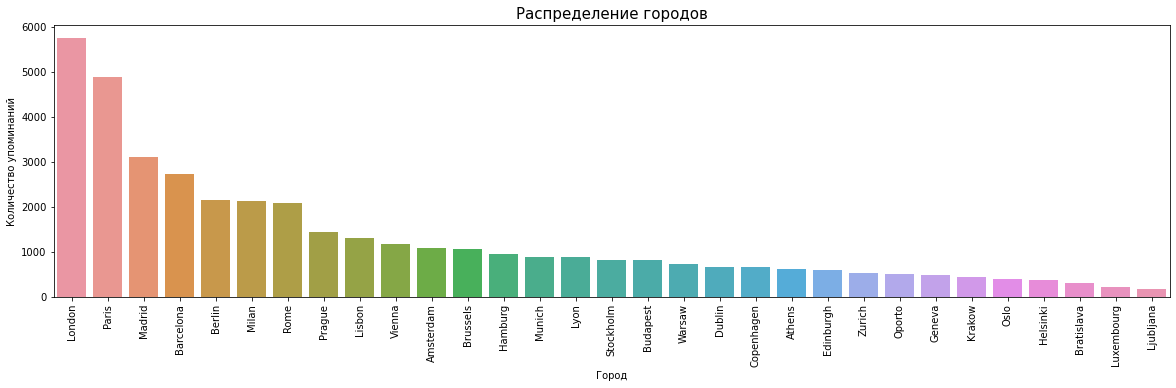

In [16]:
plt.figure(figsize=(20, 5))
sns.barplot(x=df_cities_count.index, y=df_cities_count)
plt.title('Распределение городов', fontsize=15)
plt.ylabel('Количество упоминаний')
plt.xticks(rotation=90)
plt.xlabel('Город')

Из представленного графика видно, что распрделение неравномерное. Количество упоминаний некоторых городов в дата-сете оказалось мало по сравнению с лидерами данного столбца. В дальнейшем можно преобразовать данный столбец в dummy-переменные. Но для этого стоит немного уменьшить количество присутствующих здесь переменных. посмотрим процентное соотношение упоминаний каждого города:

In [17]:
df_sum_cities = len(df.city)
# Показывает, сколько % упоминаний данного города от общего кол-ва значений в city
city_to_all = df_cities_count/df_sum_cities*100
city_to_all

London        14.3925
Paris         12.2425
Madrid         7.7700
Barcelona      6.8350
Berlin         5.3875
Milan          5.3325
Rome           5.1950
Prague         3.6075
Lisbon         3.2500
Vienna         2.9150
Amsterdam      2.7150
Brussels       2.6500
Hamburg        2.3725
Munich         2.2325
Lyon           2.2300
Stockholm      2.0500
Budapest       2.0400
Warsaw         1.8175
Dublin         1.6825
Copenhagen     1.6475
Athens         1.5700
Edinburgh      1.4900
Zurich         1.3450
Oporto         1.2825
Geneva         1.2025
Krakow         1.1075
Oslo           0.9625
Helsinki       0.9400
Bratislava     0.7525
Luxembourg     0.5250
Ljubljana      0.4575
Name: city, dtype: float64

Мы видим, что некоторые города занимают 2% и менее в общем списке. Такие города являются редкими и  дальнейшем их можно будет заменить значением 'Other'. Кроме того, столбец city может нам помочь в дальнейшем при создании новых признаков.

### 2.1.3. Столбец cuisine_style

#### А что это такое и с чем его едят?

Для начала посмотрим на то, как представлен столбец cuisine

In [18]:
type(df.cuisine_style[0])

str

Данные в ячейке представлены ввиде строки, но что же внутри нее?
Рассмотрим на примере строки 4:

In [19]:
df.cuisine_style[4]

"['German', 'Central European', 'Vegetarian Friendly']"

Теперь мы видим, что внутри строки находится список с названием кухни. 
Проверим сколько всего таких вариаций:

In [20]:
df.cuisine_style.value_counts(dropna=False)

NaN                                                                                                                         9283
['Italian']                                                                                                                 1032
['French']                                                                                                                   805
['Spanish']                                                                                                                  695
['French', 'European']                                                                                                       405
                                                                                                                            ... 
['Italian', 'Fast Food', 'Mediterranean', 'Delicatessen', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']       1
['French', 'British', 'Welsh']                                                                   

Из полученнго результата видно, что для дальнейшей работы будет разумно выделить отдельно список всех представленных в ресторанах кухонь. Также, наибольшее количество значений в списке занимает NaN, с этим необходимо что-то придумать.
Можно было бы заполнить значения самой часто встречаемой кухней, но логичнее будет заполнить значением ['no_information'].

In [21]:
df['cuisine_style'] = df.cuisine_style.apply(
    lambda x: "'no_information'" if pd.isna(x) else x)

Пол дела сделано. Теперь для комфортной работы со столбцом осталось преобразовать значения строки в массивы данных:

In [22]:
df.cuisine_style = df.cuisine_style.apply(lambda x: str(x)[1:-1].split(', '))

Посмотрим что вышло:

In [23]:
type(df.cuisine_style[0])

list

Замечательно! Теперь значения столбца представляют собой массивы, внутри которых можно будет искать необходимые нам данные.

#### Подготовим пищу для размышлений

Теперь, когда у нас есть возможность работать с представленными кухнями, можно сформировать список с суммарным количеством их упоминаний:

In [24]:
all_cuisines = df.cuisine_style.explode().value_counts()
all_cuisines

'Vegetarian Friendly'    11189
'European'               10060
no_information            9283
'Mediterranean'           6277
'Italian'                 5964
                         ...  
'Xinjiang'                   1
'Latvian'                    1
'Salvadoran'                 1
'Burmese'                    1
'Yunnan'                     1
Name: cuisine_style, Length: 126, dtype: int64

Давайте более наглядно посмотрим, сколько раз встречается та или иная кухня в дата-сете:

Text(0.5, 0, 'Кухня')

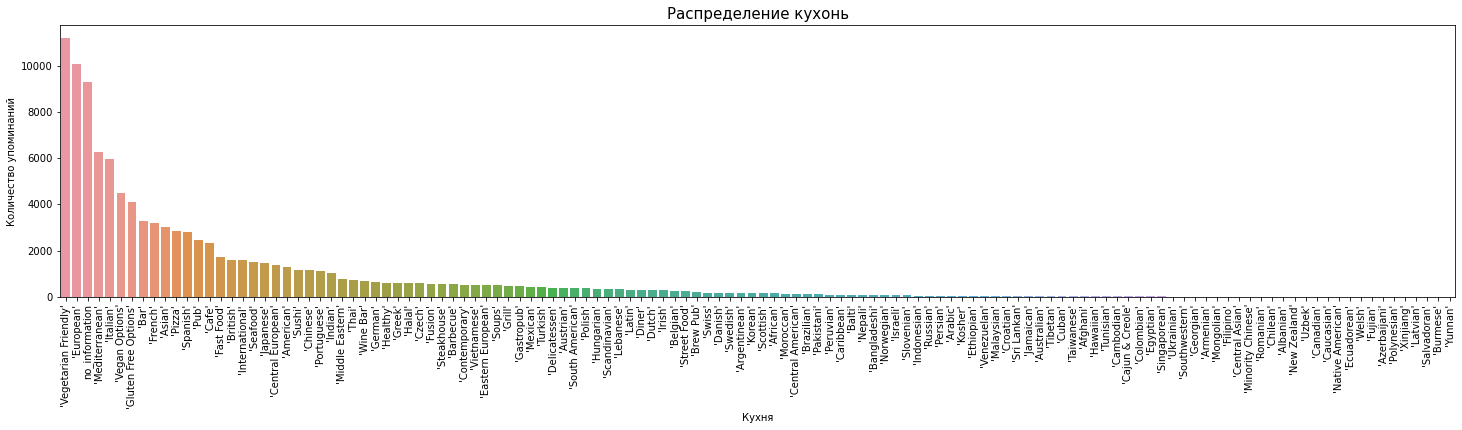

In [25]:
plt.figure(figsize=(25, 5))
sns.barplot(x=all_cuisines.index, y=all_cuisines)
plt.title('Распределение кухонь', fontsize=15)
plt.ylabel('Количество упоминаний')
plt.xticks(rotation=90)
plt.xlabel('Кухня')

Как можно увидеть из графика, распределение экспоненциальное,а значит все кухни обладают одинаковой популярностью. Поэтому можно выделить из всего этого списка самые "модные" кухни и сформировать топ (возьмем 10 самых популярных). Такой список поможет создать новые признаки, например "присутствует ли кухня из топ-10 в данном ресторане".

In [26]:
# берем 11 индексов,т.к. присутствует no_information
top_cuisines = list(all_cuisines.index[0:11])
top_cuisines

["'Vegetarian Friendly'",
 "'European'",
 'no_information',
 "'Mediterranean'",
 "'Italian'",
 "'Vegan Options'",
 "'Gluten Free Options'",
 "'Bar'",
 "'French'",
 "'Asian'",
 "'Pizza'"]

Как можно заметить, мы взяли 11 значений, а не 10 как требовалось. Это связано с тем, что в списке кухонь 3 место занимает значение "no_information". Так как особой пользы оно нам не принесет, от него стоит избавиться:

In [27]:
top_cuisines.remove("no_information")
top_cuisines

["'Vegetarian Friendly'",
 "'European'",
 "'Mediterranean'",
 "'Italian'",
 "'Vegan Options'",
 "'Gluten Free Options'",
 "'Bar'",
 "'French'",
 "'Asian'",
 "'Pizza'"]

Список из топ-10 кухонь по всему предоставленному дата-сету сформирован и готов к дальнейшему использованию.

### 2.1.4. Стобец price_range

Со столбцом price_range можно проделать несколько манипуляций, зависит только от того, что даст лучший результат.
Для начала взглянем на то,насколько данный столбец заполнен:

In [28]:
df.price_range.value_counts(dropna=False)

$$ - $$$    18412
NaN         13886
$            6279
$$$$         1423
Name: price_range, dtype: int64

Из полученных данных видно, что присутствует очень большое количество пропусков. Необходимо подумать,как лучше с ними поступить. На мой взлгяд, будет допустимо заполнить их значением моды, давайте попробуем это реализовать:

In [29]:
# заменяем пропуски значением моды
df.price_range = df.price_range.fillna(df.price_range.mode()[0])

Теперь проверим, как изменилось количество значений

In [30]:
df.price_range.value_counts(dropna=False)

$$ - $$$    32298
$            6279
$$$$         1423
Name: price_range, dtype: int64

Средний ценовой сегмент стал преобладать более выраженно,но в целом общая картина осталась прежней. В дальнейшем этот столбец можно будет преобразовать в числовой формат для обучения модели.

### 2.1.5. Столбец reviews

#### Истина где-то рядом

Давайте взглянем на столбец reviews еще раз более внимательно

In [31]:
df.reviews[10]

'[[], []]'

Видно, что в данном столбце находится строка,внутри которой два списка:с комментариями и с датами. Нам нужен будет второй список, но об этом более подробно в Feature Engeneering.

### 2.1.6. Столбцы url_ta и id_ta

#### Столбец url_ta

Данный столбец содержит ссылку на ресторан в TripAdvisor и не представляет особого интереса. 

In [32]:
df.url_ta[0]

'/Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html'

#### Столбец id_ta

Столбец содержит id комментария в TripAdvisor. В целом интереса не представляет, единственное, что можно проверить - все ли значения в тестовом наборе являются уникальными:

In [33]:
# Вычитаем из количества всех значений количество уникальных
len(df.id_ta) - df.id_ta.nunique()

20

Мы видим, что присутствуют значения, которые встречаются больше одного раза. Посмотрим внимательнее:

In [34]:
df_id_ta = df.id_ta.value_counts()
# формируем фрейм, записывая в него значения id_ta, которые встречаются больше 1 раза
df_doubles = df[df.id_ta.apply(lambda x:(df_id_ta[x] > 1))]

Теперь взглянем, что вышло:

In [35]:
df_doubles.sort_values(by=['id_ta'])

,rest_id,city,cuisine_style,ranking,rating,price_range,reviews_number,reviews,url_ta,id_ta
38946,id_3242,Madrid,[no_information],3244.0,5.0,$$ - $$$,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799
13980,id_3239,Madrid,[no_information],3241.0,5.0,$$ - $$$,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799
11583,id_3810,Madrid,"['American', 'German', 'European', 'Central Eu...",3812.0,4.0,$$ - $$$,8.0,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463
4732,id_3804,Madrid,"['American', 'German', 'European', 'Central Eu...",3806.0,4.0,$$ - $$$,8.0,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463
26551,id_3240,Madrid,[no_information],3242.0,4.5,$$ - $$$,7.0,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990
26431,id_3238,Madrid,[no_information],3240.0,4.5,$$ - $$$,7.0,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990
10819,id_2197,Madrid,[no_information],2199.0,4.5,$$ - $$$,16.0,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719
12628,id_2329,Madrid,[no_information],2331.0,4.5,$$ - $$$,16.0,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719
29879,id_3662,Madrid,"['International', 'Mediterranean', 'Spanish', ...",3664.0,4.0,$$ - $$$,52.0,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,d11999956
16920,id_3536,Madrid,"['International', 'Mediterranean', 'Spanish', ...",3538.0,4.0,$$ - $$$,52.0,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,d11999956


Мы видим, что это действительно задублированные значения. различаются только столбцы с id ресторана и с самим рангом ресторана. Но по условиям задания, строки удалять мы не имеем права, поэтому более этот столбец интереса не представляет.
Удалим из дата-фрема эти столбцы:

In [36]:
df.drop(columns=['url_ta', 'id_ta'], inplace=True)

### 2.2. Числовые столбцы

### 2.2.1. Столбец ranking

#### Попытаемся понять, что делать.

Сам по себе, столбец ranking говорит нам о том, какой ранг занимает ресторан. Но смотреть распределение значений, опираясь только на этот столбец - занятие плохое. Распрделение будет экспоненциальным, потому что разные города имеют разный процент упоминания в дата-фрейме (п.2.1.2). Да и в самом начале сказано, что это ранг, занимаемый рестораном относительно других в том же городе.
Посмотрим, есть ли пропущенные значения в данном столбце:

In [37]:
df.ranking.isnull().sum()

0

Пустых значений не наблюдается, что очень хорошо.
Теперь можно посмотреть распределение рангов по городам:

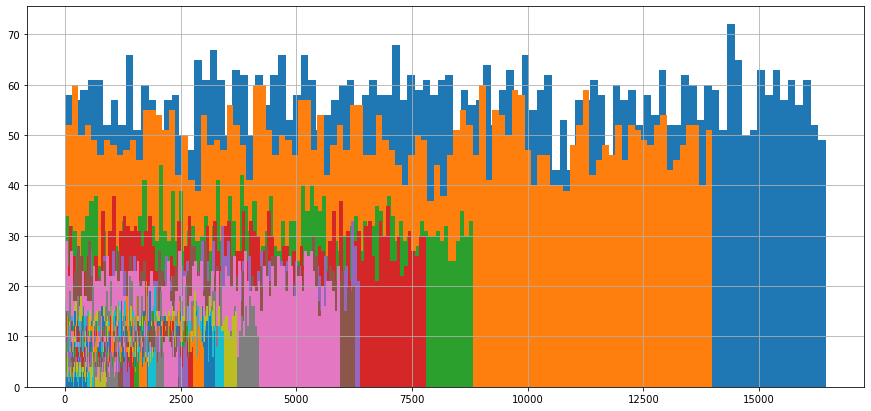

In [38]:
for town in (df.city.value_counts()).index:
    df.ranking[df.city == town].hist(bins=100)
plt.show()

Как мы видим, во всех городах распределение равномерное. Для формирования дальнейших признаков будем иметь это ввиду.
Напоследок проверим на наличие выбросов:

In [39]:
IQR = df.ranking.quantile(0.75) - df.ranking.quantile(0.25)
perc25 = df.ranking.quantile(0.25)  # 25-й перцентиль
perc75 = df.ranking.quantile(0.75)  # 75-й перцентиль

print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR,
                                           l=perc75 + 1.5*IQR))

25-й перцентиль: 973.0, 75-й перцентиль: 5260.0, IQR: 4287.0,  Границы выбросов: [-5457.5, 11690.5].


IQR говорит, что выбросами являются все значения выше 11644, однако здравый смысл подсказывает, что ресторанов в Лондоне и Париже довольно много, и ранг ресторана может быть действительно довольно высоким. Оставим без изменений.

### 2.2.2. Столбец reviews_number

Столбец отражает количество отзывов о том или ином заведении. Для начала посмотрим, сколько пропусков в данном столбце:

In [40]:
df.reviews_number.isnull().sum()

2543

Итого, 3200 значений. Не так много, можно заполнить их либо нулями, либо медианным значением. На мой взгляд, медианным значением будет заполнить лучше, реализуем данный процесс:

In [41]:
# Заполним отсутствующие значения медианным:
df.reviews_number = df.reviews_number.apply(
    lambda x: df.reviews_number.median() if pd.isna(x) else x)

Теперь проверим, все ли значения заменились на медиану:

In [42]:
df.reviews_number.isnull().sum()

0

Теперь посмотрим распределение количества отзывов:

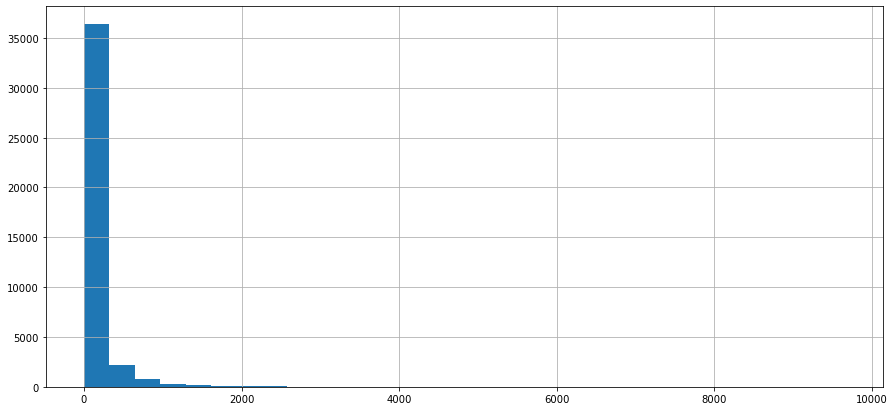

In [43]:
df.reviews_number.hist(bins=30)

Распределение количества отзывов является экспоненциальным,отрицательных значений нет. Теперь посмотрим есть ли выбросы:

In [44]:
IQR = df.reviews_number.quantile(0.75) - df.reviews_number.quantile(0.25)
perc25 = df.reviews_number.quantile(0.25)  # 25-й перцентиль
perc75 = df.reviews_number.quantile(0.75)  # 75-й перцентиль

print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR,
                                           l=perc75 + 1.5*IQR))

25-й перцентиль: 10.0, 75-й перцентиль: 105.0, IQR: 95.0,  Границы выбросов: [-132.5, 247.5].


Проверим, сколько значений находится выше верхней границы выбросов:

In [45]:
df.reviews_number[df.reviews_number > 247.5].count()

4853

Примерно 1\9 часть значений выше границ выбросов, согласно IQR. Но, для городов с большим населением - не удивительно иметь много отзывов у ресторана.  Поэтому также оставим без изменений.

### 2.2.3. Целевой столбец rating

Теперь можно взглянуть на целевой столбец rating:

In [46]:
df.rating.unique()

array([3.5, 4. , 4.5, 5. , 3. , 2.5, 2. , 1. , 1.5])

Пропусков нет, это замечательно. Посмотрим на распределение:

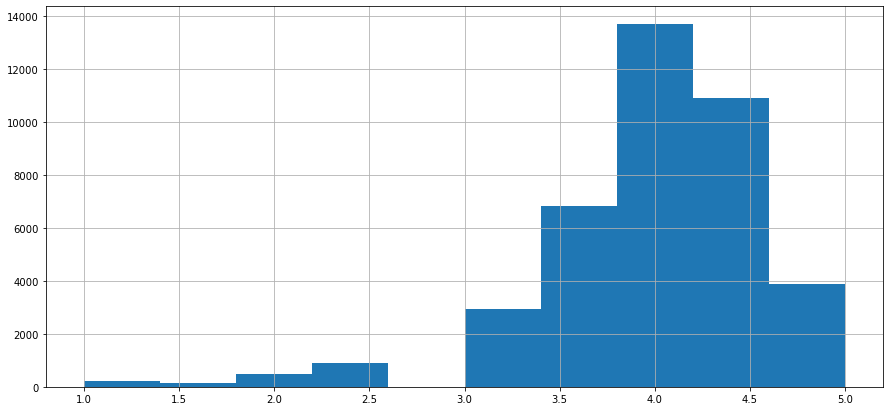

In [47]:
df.rating.hist()

Выбросов не наблюдается, оценки лежат в диапазоне 0-5. Само распределение вполне адекватное, оценки кратны 0.5. В дальнейшем, для снижения погрешности можно написать функцию, которая будет округлять предсказанные оценки в соответствии с представленной градацией. Это поможет снизить MAE.

Функция predict_rounder представлена в начале работы.

Теперь все столбцы рассмотрены, можно переходить к самому интересному - выделению новых признаков.

## 3. Future Engeneering

### 3.1. Новые столбцы из нечисловых

Для начала, создадим новые столбцы на основе тех, которые мы рассмотрели в пунтке 2.1.

### 3.1.1. Столбец cuisine_style

На основе списка, сформированного при рассмотрении кухонь мы создадим новый столбец, описывающий присутствие или отсутствие кухни из топ-10 в ресторане. Для этого напишем функцию, которая будет возвращать 1, если хотя бы 1 кухня ресторана находится в топ-10, и 0, если нет:

Функция top_check представлена в начале работы

Теперь применим функцию и сформируем новый столбец:

In [48]:
df['top_cuisine'] = df.cuisine_style.apply(lambda x: top_check(x))

Теперь мы имеем новый столбец top_cuisine, перейдем к следующему признаку. Им является количество кухонь в каждом ресторане:

In [49]:
# если в ресторане нет информации о кухне, заменяем на 0
df['cuisine_num'] = df.cuisine_style.apply(
    lambda x: 0 if x[0] == "no_information" else len(x))

Итак, мы сформировали столбец, отражающий количество кухонь в каждом ресторане,посмотрим распределение значений:

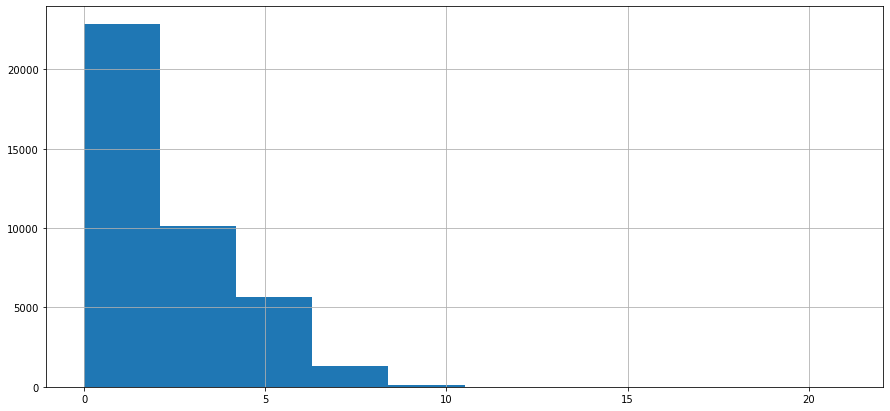

In [50]:
df.cuisine_num.hist()

### 3.1.2. Столбец price_range

Есть несколько вариантов получить новые столбцы из price_range. Используем label-encoding для создания столбца price_numeric:

In [51]:
# заменим значения на 1,2 и 3 соответственно
df['price_numeric'] = df.price_range.apply(
    lambda x: 1 if x == '$' else (2 if x == '$$ - $$$' else 3))

Мы создали новый столбец price_numeric, в котором обозначения для бюджетного,среднего и высокого ценовых сегментов заменены на 1,2 и 3 соответственно.
Посмотрим на распределение значений столбца:

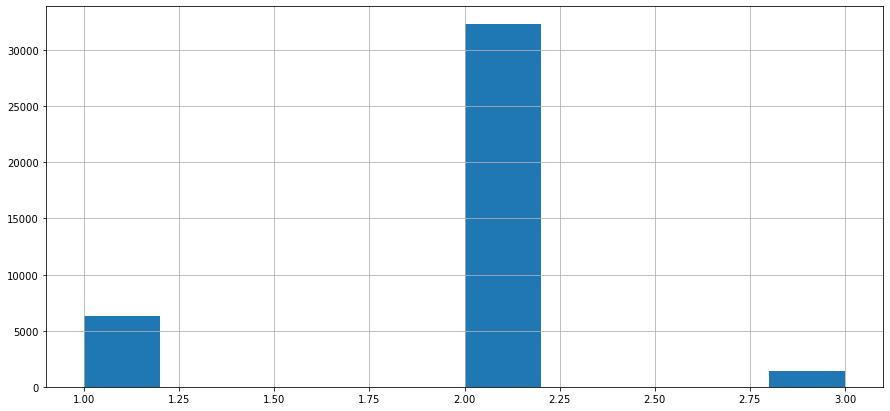

In [52]:
df.price_numeric.hist()

Распределение нормальное, большая часть значений сконцентрирована в значении 2. Это говорит о том, что большая часть ресторанов относится к среднему ценовому сегменту.

### 3.1.3. Столбец reviews

Из столбца reviews можно выделить даты отзывов и, что важнее, разницу между самым старым и новым отзывами. Для этого напишем функцию, которая будет выделять из столбца reviews даты и сохранять их в столбце dates_of_reviews:

Функция review_dates представлена в начале работы

Теперь сформируем столбец с датами:

In [53]:
df['dates_of_reviews'] = df.reviews.apply(review_dates)

Теперь сформируем столбец, отражающий разницу между самым старым и новым отзывами:

In [54]:
# считаем дни между отзывами, если значение в столбце с датами не пустое,иначе записываем 0
df['reviews_time_gone'] = df.dates_of_reviews.apply(
    lambda x: (x[1]-x[0]).days if len(x) == 2 else 0)

Мы сформировали столбец reviews_time_gone, который можно использовать для обучения будущей модели. Посмотрим распределение

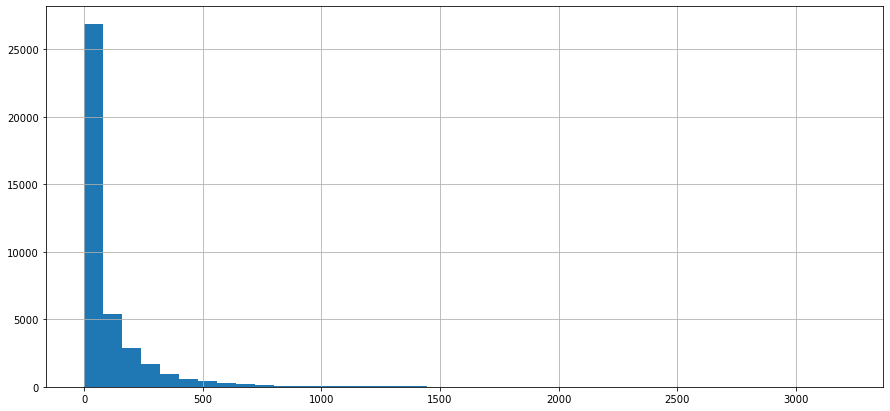

In [55]:
df.reviews_time_gone.hist(bins=40)

Распределение снова экспоненциальное, большая часть значений сосредоточена в промежутке от 0 до 400. Это говорит о том, что для многих заведений между отзывами прошло не более двух лет. Причин этому может быть несколько - либо заведение новое, либо оно не числилось раньше на TripAdvisor. А возможно людям было просто лень писать отзывы. 

### 3.1.4. Столбец rest_id

На основе данного столбца мы можем сформировать столбец, показывающий является ли ресторан сетевым или нет. Для этого сформируем список с ресторанами, которых больше 1:

In [56]:
id_net = id_list[id_list > 1]

Теперь сформируем список из id сетевых ресторанов:

In [57]:
id_net_list = list(id_net.index)
id_net_list

['id_436',
 'id_227',
 'id_633',
 'id_871',
 'id_321',
 'id_344',
 'id_430',
 'id_534',
 'id_71',
 'id_585',
 'id_364',
 'id_335',
 'id_589',
 'id_920',
 'id_367',
 'id_256',
 'id_152',
 'id_107',
 'id_79',
 'id_69',
 'id_561',
 'id_245',
 'id_482',
 'id_792',
 'id_167',
 'id_206',
 'id_200',
 'id_1076',
 'id_434',
 'id_1697',
 'id_837',
 'id_479',
 'id_216',
 'id_175',
 'id_607',
 'id_1055',
 'id_847',
 'id_611',
 'id_477',
 'id_85',
 'id_66',
 'id_38',
 'id_267',
 'id_453',
 'id_779',
 'id_237',
 'id_150',
 'id_991',
 'id_279',
 'id_92',
 'id_1079',
 'id_995',
 'id_660',
 'id_458',
 'id_105',
 'id_0',
 'id_1009',
 'id_359',
 'id_14',
 'id_54',
 'id_86',
 'id_425',
 'id_885',
 'id_330',
 'id_830',
 'id_445',
 'id_492',
 'id_756',
 'id_2',
 'id_681',
 'id_971',
 'id_549',
 'id_615',
 'id_10',
 'id_315',
 'id_845',
 'id_835',
 'id_692',
 'id_693',
 'id_21',
 'id_905',
 'id_959',
 'id_866',
 'id_1060',
 'id_624',
 'id_101',
 'id_872',
 'id_969',
 'id_581',
 'id_487',
 'id_1239',
 'id_122

Далее напишем функцию, которая будет возвращать 1, если id ресторана находится в списке сетевых и 0 если нет:

Функция is_net_rest представлена в начале работы

Теперь преобразуем значения в ячейках rest_id в список:

In [58]:
df.rest_id = df.rest_id.apply(lambda x: x.split(','))

Далее сформируем сам столбец:

In [59]:
df['net_rest'] = df.rest_id.apply(lambda x: is_net_rest(x))

Проверим результат:

In [60]:
df.net_rest.value_counts()

1    35295
0     4705
Name: net_rest, dtype: int64

Итого мы получили 4705 уникальных ресторанов со значением 0. Все остальные являются сетевыми.

### 3.2. Числовые столбцы

Рассмотрим столбцы из пункта 2.2

### 3.2.1. Столбец ranking

Данный столбец отражает ранг ресторана относительно других ресторанов в его городе. Можно отнормировать относительно максимального ранга. для этого сформируем словарь, вкотором будут храниться максимальные значения для каждого города:

In [61]:
city = df.city.unique()
city_rank = {}  # создаем пустой словарь
# записываем в словарь значения максимума по каждому городу
for i in city:
    city_rank[i] = df[df.city == i].ranking.max()

Теперь отнормируем столбец ranking относительно полученных значений:

In [62]:
df['ranking_norm'] = df[['city', 'ranking']].apply(
    lambda x: x[1]/city_rank[x[0]], axis=1)

Теперь значения столбца имеют меньший разброс, что может помочь сделать более четкий прогноз.

### 3.2.2. Столбец reviews_number

Данный столбец отражает количество отзывов каждом из ресторанов. Приведем все значения столбца к значению между 0 и 1:

In [63]:
# из каждого значения вычитается минимум столбца, затем все делится на разность между максимумом и минимумом
df['reviews_num_norm'] = df.reviews_number.apply(lambda x: (
    x-df.reviews_number.min())/(df.reviews_number.max()-df.reviews_number.min()))

### Проведём корреляционный анализ

Для того, чтобы исключить высококоррелированные столбцы, посмотрим на корреляции между ними:

In [64]:
correlation = df.drop(
    columns=['reviews_number', 'ranking']).corr(method='pearson')
correlation

,rating,top_cuisine,cuisine_num,price_numeric,reviews_time_gone,net_rest,ranking_norm,reviews_num_norm
rating,1.000000,0.076070,0.113886,-0.028588,-0.065990,0.223689,-0.544573,0.027229
top_cuisine,0.076070,1.000000,0.693318,-0.048826,-0.038334,0.135576,-0.412628,0.258060
cuisine_num,0.113886,0.693318,1.000000,-0.029666,-0.101238,0.157700,-0.543859,0.395179
price_numeric,-0.028588,-0.048826,-0.029666,1.000000,-0.039184,0.008983,-0.047477,0.108568
reviews_time_gone,-0.065990,-0.038334,-0.101238,-0.039184,1.000000,-0.047461,0.106435,-0.090588
net_rest,0.223689,0.135576,0.157700,0.008983,-0.047461,1.000000,-0.319785,0.102318
ranking_norm,-0.544573,-0.412628,-0.543859,-0.047477,0.106435,-0.319785,1.000000,-0.401283
reviews_num_norm,0.027229,0.258060,0.395179,0.108568,-0.090588,0.102318,-0.401283,1.000000


Для большей наглядности посмотрим, есть ли столбцы с корреляцией больше 0.7:

In [65]:
correlation[(correlation > 0.7) | (correlation < -0.7)].fillna('')

,rating,top_cuisine,cuisine_num,price_numeric,reviews_time_gone,net_rest,ranking_norm,reviews_num_norm
rating,1,,,,,,,
top_cuisine,,1,,,,,,
cuisine_num,,,1,,,,,
price_numeric,,,,1,,,,
reviews_time_gone,,,,,1,,,
net_rest,,,,,,1,,
ranking_norm,,,,,,,1,
reviews_num_norm,,,,,,,,1


Видно, что таких значений не наблюдается, переходим к следующему шагу.

### 3.3. Столбцы для преобразования в dummie-переменные

### Столбец city

Данный столбец можно преобразовать в dummie-переменные. Для начала, как писалось в пукте 2.1.2, заменим значения всех городов, вклад которых в общую картину составляет менее 2%, на other и сохраним в новый столбец city_new:

In [66]:
df['city_new'] = df.city.apply(lambda x: x if city_to_all[x] > 2 else 'other')

А теперь преобразуем полученный столбец в dummie-переменные:

In [67]:
df = pd.get_dummies(df, columns=['city_new'], prefix='city')

Посмотрим, что получилось:

In [68]:
df.head()

,rest_id,city,cuisine_style,ranking,rating,price_range,reviews_number,reviews,top_cuisine,cuisine_num,...,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_other
0,[id_5569],Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",1,3,...,0,0,0,0,1,0,0,0,0,0
1,[id_1535],Stockholm,[no_information],1537.0,4.0,$$ - $$$,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",0,0,...,0,0,0,0,0,0,0,1,0,0
2,[id_352],London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",1,7,...,0,0,0,0,0,0,0,0,0,0
3,[id_3456],Berlin,[no_information],3458.0,5.0,$$ - $$$,3.0,"[[], []]",0,0,...,0,0,0,0,0,0,0,0,0,0
4,[id_615],Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",1,3,...,0,0,0,1,0,0,0,0,0,0


# 4. Работа с Моделью

In [69]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['rest_id', 'rating', 'city', 'cuisine_style', 'ranking',
             'price_range', 'reviews_number', 'reviews', 'dates_of_reviews'], axis=1)
y = df['rating']

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [70]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

# Модель
Сам ML

In [71]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [72]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [73]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21174749999999998


Теперь,получив значение метрики, используем написанную ранее функцию для округления значений, ведь все оценки в дата-фрейме представлены с шагом 0.5:

In [74]:
y_pred_rounded = predict_rounder(y_pred)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_rounded))

MAE: 0.1828125


Получилось гораздо лучше, чем было изначально.

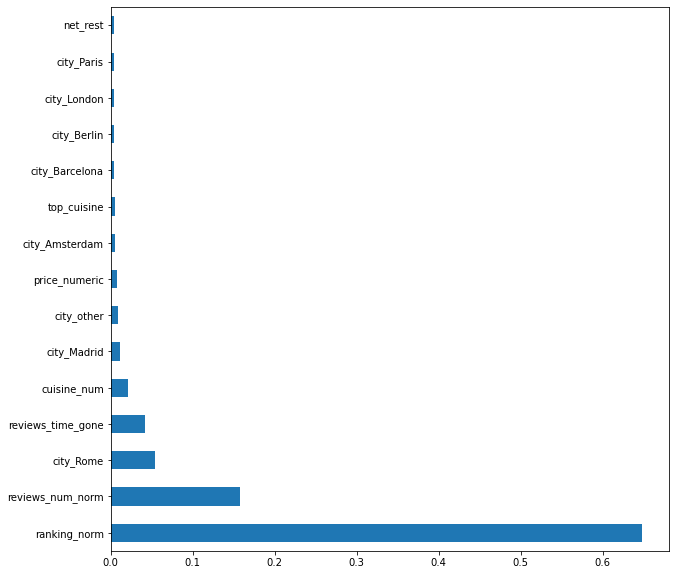

In [75]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

Из финального графика видно, что больше всего оказывают влияние столбцы ranking_norm, reviews_num_norm, city_Rome и reviews_time_gone. Влияние остальных признаков на предсказание существенно меньше. В дальнейшем, можно создать более интересные и сложные признаки, которые помогут еще улучшить MAE.

Не меньшую роль сыграло заполнение пропусков определенными значениями. Возможно, если провести более детальный анализ, можно придумать более правильное определение каждого пропуска или групп пропусков в столбцах.